In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from copy import deepcopy as copy

In [5]:
env = gym.make('LunarLander-v2')#LunarLander-v2

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
# %%

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, env_n, action_n):
        super(DQN, self).__init__()
        self.out_size = action_n
        hidden_size = 400
        self.dense1 = nn.Linear(env_n, hidden_size)
        self.nl1 = nn.ReLU()
        self.dense2 = nn.Linear(hidden_size, hidden_size //2)
        self.dense_out = nn.Linear(hidden_size //2, self.out_size)
        self.sm = nn.Softmax()

    def forward(self, x):
        # print(x)
        # if len(x.data.shape) < 2:
        #     x = x.view(1, -1)
        out = self.dense1(x)
        out = self.nl1(out)
        out = self.dense2(out)
        out = self.nl1(out)
        out = self.dense_out(out)
        return out.view(x.size(0), -1)

[2017-11-05 04:38:58,711] Making new env: LunarLander-v2


In [6]:
env.reset()

action_n = env.action_space.n

BATCH_SIZE = 100
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 50



model = DQN(env.observation_space.shape[0], action_n)
list(model.parameters())
if use_cuda:
    model.cuda()

optimizer = optim.Adamax(model.parameters(), lr=0.005)
memory = ReplayMemory(10000)


steps_done = 0
model_actions = []

In [7]:
observation_samples = []
for n in range(1000):
    observation = env.reset()
    observation_samples.append(observation)
    done = False
    while not done:
        action = np.random.randint(0, env.action_space.n)
        observation, reward, done, _ = env.step(action)
        observation_samples.append(observation)
observation_samples = np.array(observation_samples)
scaler = StandardScaler()
scaler.fit(observation_samples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
def select_action(state, model):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # print(Variable(FloatTensor(state), volatile=True).type(FloatTensor).data.max(0)[1])
        act = model(Variable(FloatTensor(state), volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
        return act
    else:
        return LongTensor([[random.randrange(env.action_space.n)]])

episode_durations = []
last_sync = 0
loss_l = torch.nn.MSELoss()
all_loss = []
tmp = None
weight_update_ratio = 3
counter_optim = 0
old_model = copy(model)

def optimize_model():
    global last_sync
    global tmp
    global counter_optim
    global weight_update_ratio
    global old_model
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    # print(Variable(torch.cat(batch.state)))
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    state_action_values = model(state_batch).gather(1, action_batch)
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    # DDQN
#     argmax_new = model(non_final_next_states).max(1)[1].view(-1, 1)
#     old_model_values = model(non_final_next_states)
#     print(argmax_new.view(-1, 1))
#     print(old_model_values)
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0] #.gather(1, argmax_new)
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    tmp = (state_action_values, expected_state_action_values)
    loss = F.mse_loss(state_action_values, expected_state_action_values)
    # print(loss)
    # Optimize the model
    optimizer.zero_grad()
    all_loss.append(loss.data[0])
    loss.backward()
    # for param in model.parameters():
    #     # param.grad.data.clamp_(-1, 1)
    optimizer.step()
#     if counter_optim % weight_update_ratio == 0:
#         old_model = copy(model)
#         for param in old_model.parameters():
#             param.requires_grad = False
    counter_optim+=1

In [9]:
num_episodes = 300
mean_by_episode_reward = []
for i_episode in range(num_episodes):
    rwrds = []
    state = FloatTensor([scaler.transform(np.atleast_2d(env.reset()))])
    for t in count():
        action = select_action(state, model)
        st, reward, done, _ = env.step(action[0, 0])
        rwrds.append(reward)
        reward = Tensor([reward])
        if not done:
            next_state = FloatTensor([scaler.transform(np.atleast_2d(st))])
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            mean_by_episode_reward.append(np.mean(rwrds))
            print(np.mean(rwrds))
            # plot_durations()
            break
print('Complete')
env.render(close=True)
env.close()

-2.19542267067
-2.48922687523
-3.17361582023
-3.84420914898
-2.98216877251
-4.99153050881
-10.0281836352
-10.3573939172
-4.48683933897
-6.7266704778
-2.94054520089
-6.08333249651
-7.77887460359
-9.1070005411
-6.49482607632
-4.7410477745
-3.84791265605
-3.38378267215
-8.13301128888
-3.16617696997
-4.77690810353
-5.51677125072
-3.53354749256
-4.8354671264
-3.14245031436
-4.89215523352
-2.13404359718
-1.79709101117
-1.49776479894
-3.70714632675
-3.47127197744
-1.96991458247
-3.18788556077
-6.95985834602
-4.7176372743
-8.94429934475
-9.45590500205
-2.69135672363
-2.95201552151
-1.35638254709
-1.79195004215
-3.33802705279
-2.01429768973
-1.6251863813
-2.90133836922
-3.94756195538
-1.22932112179
-1.9275696854
-0.594485390365
-2.72257459531
-1.98798724848
-0.582366776324
-0.876305027518
-0.800867542682
-0.930857316462
-1.08743496639
-0.598677410651
-0.67556950414
-0.126754718229
-0.205067512683
-0.158885530115
-0.20316919421
-0.1442762643
-0.458676794905
-0.705259438074
-0.53926365386
-0.7634

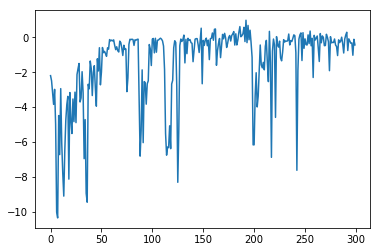

In [10]:
plt.plot(mean_by_episode_reward)

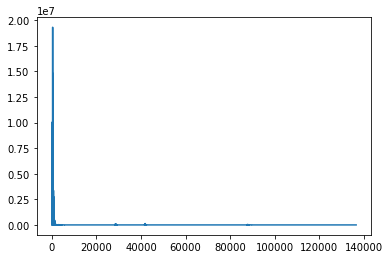

In [11]:
plt.plot(all_loss)

In [ ]:
env.close()
num_episodes = 100
mean_by_episode_reward = []
for i_episode in range(num_episodes):
    rwrds = []
    state = FloatTensor([env.reset()])
    for t in count():
        action =model(Variable(FloatTensor(state), volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
        st, reward, done, _ = env.step(action[0, 0])
        rwrds.append(reward)
        reward = Tensor([reward])
        if not done:
            next_state = FloatTensor([st])
        else:
            next_state = None
        state = next_state
        if done:
            episode_durations.append(t + 1)
            mean_by_episode_reward.append(np.mean(rwrds))
            print(np.mean(rwrds))
            # plot_durations()
            break

-2.90199177441
-0.924583428433
-0.911224014006
-0.750539033997
-0.362819347892
-0.114431424346
-0.837111141004
-2.72859416852
0.129102037764
-0.14112800759
-1.15967421643
-1.04414298093
-0.7823489646
-0.487994090381
-0.169398864934
-0.121194292804
-0.348301267565
-0.818009687393
-0.0254347819399
-1.00885083102
-0.136248873663
-0.119753641258
-0.143449543197
-0.842796139999
-0.937941234579
-1.00635806821
-0.701909371524
-1.14867263631
-1.09824634697
-0.381199410714
-1.63381241272
-0.405681977466
-0.18058133029
-0.138657870386
-1.32488351432
-1.16134781764
-0.520155870152
-0.450256263622
-0.160623835343
-0.349362694466
-0.151648492765
-0.173518910865
-0.000747040715888
-0.4976069379
-0.85414163789
0.238117326503
-0.982357612126
-0.16196735896
-1.04718438784
-0.810621166458
-0.142716751687
-0.137059341684
-0.161485391466
-1.12484931568
-0.212720047805
-1.25636414182
-0.153454134276
-1.51676409271
-0.605851027021
-0.126580747328
-1.37932056297
0.168344759059
-1.14520567153
-0.527025825959


In [ ]:
print(np.mean(mean_by_episode_reward))